In [18]:
import collections
import pathlib

# データ処理周り
import numpy as np
import pandas as pd
from IPython.core.display import display
import gc

# 可視化ライブラリ
import matplotlib.pyplot as plt
from matplotlib import cm # colormap
import seaborn as sns
%matplotlib inline

# pandasのwarningが邪魔なので
import warnings
warnings.filterwarnings('ignore')

# options
# pd.set_option('display.max_columns', 50)
plt.style.use('ggplot')


####
import sys
sys.path.append('../script')
data_path = pathlib.Path('../data')
my_data_path = pathlib.Path('../my-data')

In [3]:
%reload_ext autoreload
import talking_data as td
import preprocess 


from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance

In [11]:
# BigQueryで前処理済みのデータを1/10ロード
train = pd.DataFrame()

i = 0
n = 10
for filepath in (my_data_path / 'train_expanded').glob('*.tar.gz'):
    print(f">>> {i}")
    if i > n:
        break        
    df = pd.read_csv(filepath)
    train = pd.concat([train, df])
    i += 1

>>>0
>>>1
>>>2
>>>3
>>>4
>>>5
>>>6
>>>7
>>>8
>>>9
>>>10
>>>11


In [28]:
test = pd.DataFrame()
for filepath in (my_data_path / 'test_expanded').glob('*.tar.gz'):
    df = pd.read_csv(filepath)
    test = pd.concat([test, df])

In [14]:
# train
print("shape:", train.shape)
train.head()

shape: (39501056, 10)


,app,device,channel,os,next_click,prev_click,hour,day,attributed_time,is_attributed
0,14,1,371,18,36.0,NaN,0,8,NaN,0
1,14,1,360,10,12416.0,2485.0,0,8,NaN,0
2,11,1,319,19,2556.0,1733.0,0,9,NaN,0
3,3,1,371,13,0.0,235.0,0,8,NaN,0
4,10,1,317,19,NaN,NaN,0,8,NaN,0


In [16]:
# test
print("shape:", test.shape)
test.head()

shape: (39489349, 9)


,click_id,app,device,channel,os,next_click,prev_click,hour,day
0,8143779,65,3,469,33,539.0,705.0,9,10
1,7829342,65,3,469,33,15.0,189.0,9,10
2,7956282,65,3,469,33,NaN,NaN,9,10
3,6481421,65,3,469,33,3252.0,14235.0,9,10
4,7007579,65,3,469,33,148.0,33.0,9,10


In [17]:
y = train['is_attributed']
X = train[:]
X.drop(['attributed_time', 'is_attributed'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)
del X_train, X_test, y_train, y_test

In [19]:
# https://www.kaggle.com/joaopmpeinado/talkingdata-xgboost-lb-0-966
# Set the params(this params from Pranav kernel) for xgboost model
params = {
    'eta': 0.3,
    'tree_method': "hist",
    'grow_policy': "lossguide",
    'max_leaves': 1400,  
    'max_depth': 0, 
    'subsample': 0.9, 
    'colsample_bytree': 0.7, 
    'colsample_bylevel':0.7,
    'min_child_weight':0,
    'alpha':4,
    'objective': 'binary:logistic', 
    'scale_pos_weight':9,
    'eval_metric': 'auc', 
    'nthread':8,
    'random_state': 99, 
    'silent': True
}

In [20]:
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
model = xgb.train(params, dtrain, 200, watchlist, maximize=True, early_stopping_rounds = 25, verbose_eval=5)
del dvalid

[0]	train-auc:0.904653	valid-auc:0.907687
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[5]	train-auc:0.949894	valid-auc:0.95073
[10]	train-auc:0.960975	valid-auc:0.959536
[15]	train-auc:0.966678	valid-auc:0.959638
[20]	train-auc:0.976087	valid-auc:0.965236
[25]	train-auc:0.983879	valid-auc:0.96532
[30]	train-auc:0.989231	valid-auc:0.964684
[35]	train-auc:0.992495	valid-auc:0.964825
[40]	train-auc:0.994642	valid-auc:0.964577
[45]	train-auc:0.995586	valid-auc:0.964538
Stopping. Best iteration:
[24]	train-auc:0.982793	valid-auc:0.965473



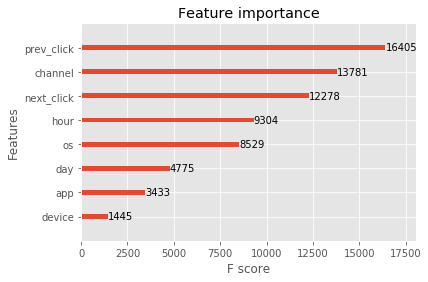

In [21]:
plot_importance(model)

In [29]:
sub = pd.DataFrame()
sub['click_id'] = test['click_id'].astype('int')

In [30]:
test.drop(['click_id'], axis=1, inplace=True)
dtest = xgb.DMatrix(test)
# del dtrain, dvalid
gc.collect()

176

In [26]:
# del train, test
# gc.collect()

37

In [31]:
sub['is_attributed'] = model.predict(dtest, ntree_limit=model.best_ntree_limit)

In [33]:
sub.to_csv(my_data_path / 'submit' / '003-BasicXgBoost.csv', float_format='%.8f', index=False)

In [34]:
sub.head()

,click_id,is_attributed
0,8143779,0.005901
1,7829342,0.009534
2,7956282,0.008523
3,6481421,0.007468
4,7007579,0.010388
